 Data Loading

In [1]:
# Importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose as SDecompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Reading in the dataset
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip', low_memory = False, sep=';', na_values='?', infer_datetime_format=True, parse_dates={'DateTime':[0,1]},index_col=['DateTime'])


Performing some exploratory data analysis(EDA)

In [3]:
df.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [6]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [7]:
df.shape # The dataset has more than two million rows and seven(7) columns

(2075259, 7)

Data Preprocessing

In [8]:
#checking null values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [9]:
#Deal with missing values using forward fill method
df= df.fillna(method='ffill')

In [10]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [11]:
# Resampling the datasets

#Sampling hourly
hourly_data = df.resample('H').mean()


#Sampling daily
daily_data = (df.resample('D').mean())

#Sampling weekly
weekly_data = df.resample('W').mean()


#Sampling monthly
monthly_data = df.resample('M').mean()


print (hourly_data.shape)
print(daily_data.shape)
print(weekly_data.shape)
print(monthly_data.shape)

(34589, 7)
(1442, 7)
(207, 7)
(48, 7)


In [12]:
daily_data.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583


Quiz questions computations

In [13]:
# Getting the pearson correlation between columns of the dataset
df.corr (method ='pearson',min_periods=1)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.246362,-0.395647,0.998884,0.484388,0.434581,0.639681
Global_reactive_power,0.246362,1.000000,-0.111775,0.265558,0.123135,0.139438,0.090631
Voltage,-0.395647,-0.111775,1.000000,-0.407454,-0.194261,-0.165659,-0.260498
Global_intensity,0.998884,0.265558,-0.407454,1.000000,0.489283,0.440359,0.627569
Sub_metering_1,0.484388,0.123135,-0.194261,0.489283,1.000000,0.055102,0.103769
Sub_metering_2,0.434581,0.139438,-0.165659,0.440359,0.055102,1.000000,0.082118
Sub_metering_3,0.639681,0.090631,-0.260498,0.627569,0.103769,0.082118,1.000000


In [14]:
# Getting the pearson correlation between columns of the downsampled(daily) dataset
daily_data.corr(method ='pearson',min_periods=1)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.041988,0.115853,0.999159,0.542202,0.479273,0.734892
Global_reactive_power,0.041988,1.000000,-0.059322,0.063671,0.316851,0.185792,0.049537
Voltage,0.115853,-0.059322,1.000000,0.089795,-0.064373,-0.071977,0.186429
Global_intensity,0.999159,0.063671,0.089795,1.000000,0.553975,0.488192,0.725905
Sub_metering_1,0.542202,0.316851,-0.064373,0.553975,1.000000,0.256330,0.319934
Sub_metering_2,0.479273,0.185792,-0.071977,0.488192,0.256330,1.000000,0.208234
Sub_metering_3,0.734892,0.049537,0.186429,0.725905,0.319934,0.208234,1.000000


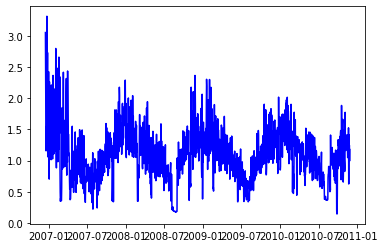

In [15]:
# Plotting the daily sampled data
dailyGAP = (daily_data['Global_active_power'])
plt.plot(dailyGAP , 'blue')


Next, We carry out fbprophet forecasting on the dataset

In [16]:
# Resampling the data again daily and summing it
daya_data = df.resample('D')
updated_df = daya_data.sum()
updated_df = updated_df.reset_index() # resetting index column
updated_df.head()

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [17]:
# Selecting Global_active_power column for univariate time series modelling
day_data= updated_df[['DateTime','Global_active_power']]
day_data =day_data.rename(columns={"DateTime": "ds", "Global_active_power": "y"})
day_data.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [18]:
# Splitting the dataset into train and test sets respectively according to the quiz instructions
df_train = day_data.loc[day_data["ds"]<"2009-11-27"]
df_test  = day_data.loc[day_data["ds"]>="2009-11-27"]

In [19]:
df_train.shape, df_test.shape

((1077, 2), (365, 2))

In [20]:
# fbprophet modelling
# Fitting the train set to the model
from fbprophet import Prophet
model = Prophet(daily_seasonality=True)
model.fit(df_train)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [21]:
# Predicting the values of the test set after dropping the 'y' column
forecast = model.predict(df_test.drop(columns="y"))
forecast.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1220.171501,1553.982909,2714.377753,1220.171501,1220.171501,874.247092,874.247092,874.247092,345.671279,345.671279,345.671279,-59.093701,-59.093701,-59.093701,587.669513,587.669513,587.669513,0.0,0.0,0.0,2094.418593
1,2009-11-28,1220.257598,1812.611929,2953.462202,1220.257598,1220.257598,1164.546066,1164.546066,1164.546066,345.671279,345.671279,345.671279,238.675756,238.675756,238.675756,580.199031,580.199031,580.199031,0.0,0.0,0.0,2384.803664
2,2009-11-29,1220.343695,1829.552947,2929.013145,1220.343695,1220.343695,1137.159187,1137.159187,1137.159187,345.671279,345.671279,345.671279,220.722751,220.722751,220.722751,570.765157,570.765157,570.765157,0.0,0.0,0.0,2357.502882
3,2009-11-30,1220.429792,1417.723164,2537.951135,1220.429792,1220.429792,743.850189,743.850189,743.850189,345.671279,345.671279,345.671279,-161.715001,-161.715001,-161.715001,559.893911,559.893911,559.893911,0.0,0.0,0.0,1964.279981
4,2009-12-01,1220.515889,1556.264423,2677.456628,1220.515889,1220.515889,869.425631,869.425631,869.425631,345.671279,345.671279,345.671279,-24.376235,-24.376235,-24.376235,548.130587,548.130587,548.130587,0.0,0.0,0.0,2089.941519


In [22]:
# Computing the RMSE by comparing the real values and the forecasted values
mse_prophet = mean_squared_error(df_test.y,forecast.yhat)
print ("RMSE FOR PROPHET {:.2f}".format(np.sqrt(mse_prophet)))

RMSE FOR PROPHET 402.02


In [23]:
# Computing the MAPE
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = df_test['y']
pred = forecast['yhat']

mape(actual, pred)

26.268128415374537

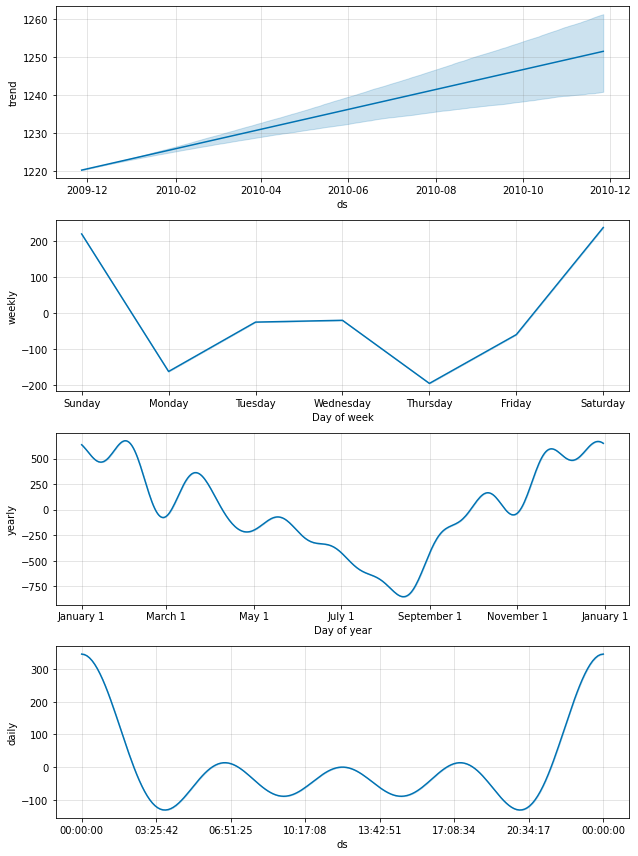

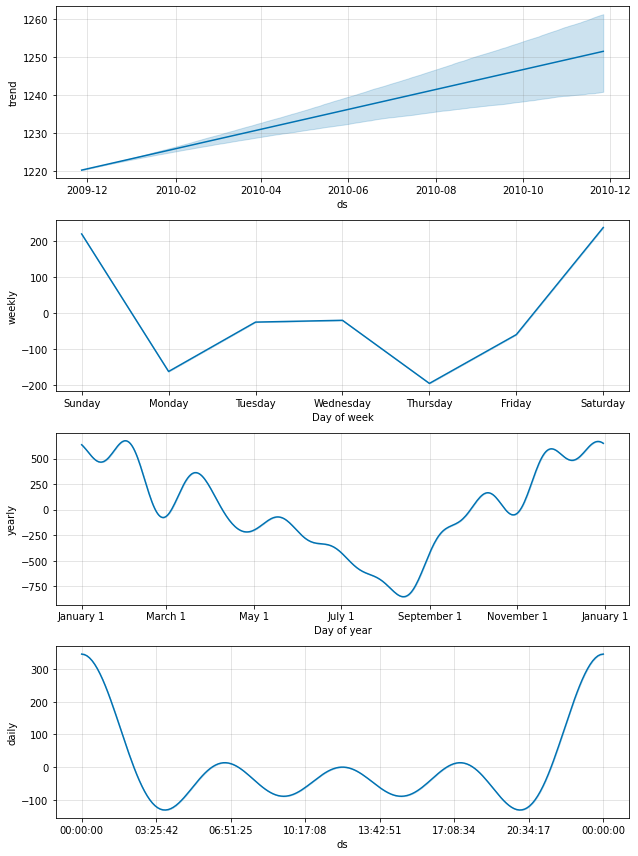

In [24]:
# Plotting the components of the forecast
model.plot_components(forecast)

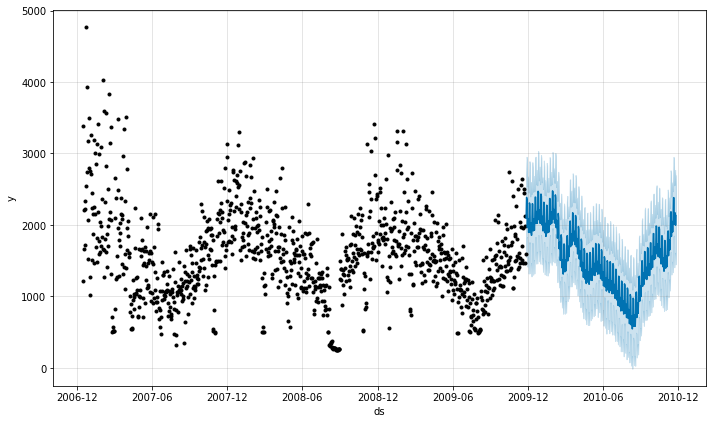

In [25]:
# Plotting the forecasted values
model.plot(forecast)
plt.show()

Multivariate Time series forecasting with Facebook Prophet

In [26]:
# we make use of our univariate dataset
day_data.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [27]:
day_data["add1"] = updated_df['Global_reactive_power']
day_data["add2"] = updated_df['Voltage']
day_data["add3"] = updated_df['Global_intensity']
day_data["add4"] = updated_df['Sub_metering_1']
day_data["add5"] = updated_df['Sub_metering_2']
day_data["add6"] = updated_df['Sub_metering_3']

In [28]:
day_data.head()

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [29]:
# Train and test sets similar to what was done before
df_train = day_data.loc[day_data["ds"]<"2009-11-27"]
df_test  = day_data.loc[day_data["ds"]>="2009-11-27"]

In [30]:
m = Prophet()
# Adding the other independent variables as regressors
m.add_regressor('add1')
m.add_regressor('add2')
m.add_regressor('add3')
m.add_regressor('add4')
m.add_regressor('add5')
m.add_regressor('add6')
m.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
# Predicting the test set after the 'y' column has been temporarily dropped
forecast1 = m.predict(df_test.drop(columns="y"))

In [32]:
forecast1.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,add2_lower,add2_upper,add3,add3_lower,add3_upper,add4,add4_lower,add4_upper,add5,add5_lower,add5_upper,add6,add6_lower,add6_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1590.824955,1364.430301,1398.650692,1590.824955,1590.824955,7.270303,7.270303,7.270303,0.595467,0.595467,0.595467,-227.305670,-227.305670,-227.305670,2.351269,2.351269,2.351269,0.823844,0.823844,0.823844,3.511136,3.511136,3.511136,-209.599614,-209.599614,-209.599614,-212.753651,-212.753651,-212.753651,-0.058805,-0.058805,-0.058805,3.212842,3.212842,3.212842,0.0,0.0,0.0,1381.225341
1,2009-11-28,1590.948509,1846.701624,1879.057954,1590.948509,1590.948509,-8.475744,-8.475744,-8.475744,0.490557,0.490557,0.490557,268.403719,268.403719,268.403719,-2.188400,-2.188400,-2.188400,0.829137,0.829137,0.829137,6.986609,6.986609,6.986609,271.253960,271.253960,271.253960,266.045877,266.045877,266.045877,1.660905,1.660905,1.660905,3.547178,3.547178,3.547178,0.0,0.0,0.0,1862.202468
2,2009-11-29,1591.072062,1629.359241,1662.236697,1591.072062,1591.072062,-2.639357,-2.639357,-2.639357,1.175225,1.175225,1.175225,52.471870,52.471870,52.471870,0.828585,0.828585,0.828585,-0.586657,-0.586657,-0.586657,-1.252954,-1.252954,-1.252954,54.002366,54.002366,54.002366,49.996713,49.996713,49.996713,0.090450,0.090450,0.090450,3.915203,3.915203,3.915203,0.0,0.0,0.0,1645.074428
3,2009-11-30,1591.195615,1726.729328,1759.147568,1591.195615,1591.195615,3.797036,3.797036,3.797036,1.357394,1.357394,1.357394,136.757713,136.757713,136.757713,0.818652,0.818652,0.818652,0.842368,0.842368,0.842368,4.067009,4.067009,4.067009,151.599093,151.599093,151.599093,147.640173,147.640173,147.640173,-0.362804,-0.362804,-0.362804,4.321724,4.321724,4.321724,0.0,0.0,0.0,1742.794708
4,2009-12-01,1591.319168,1746.362614,1780.158131,1591.319168,1591.319168,5.763114,5.763114,5.763114,0.905092,0.905092,0.905092,155.959067,155.959067,155.959067,2.351269,2.351269,2.351269,0.846073,0.846073,0.846073,2.528250,2.528250,2.528250,171.402900,171.402900,171.402900,168.352865,168.352865,168.352865,-1.720697,-1.720697,-1.720697,4.770732,4.770732,4.770732,0.0,0.0,0.0,1762.722068


In [33]:
# Computing the RMSE by comparing the real values and the forecasted values
mse_prophet = mean_squared_error(df_test.y,forecast1.yhat)
print ("RMSE FOR PROPHET {:.2f}".format(np.sqrt(mse_prophet)))

RMSE FOR PROPHET 40.61


In [34]:
# Computing the MAPE
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = df_test['y']
pred = forecast['yhat']

mape(actual, pred)

26.268128415374537

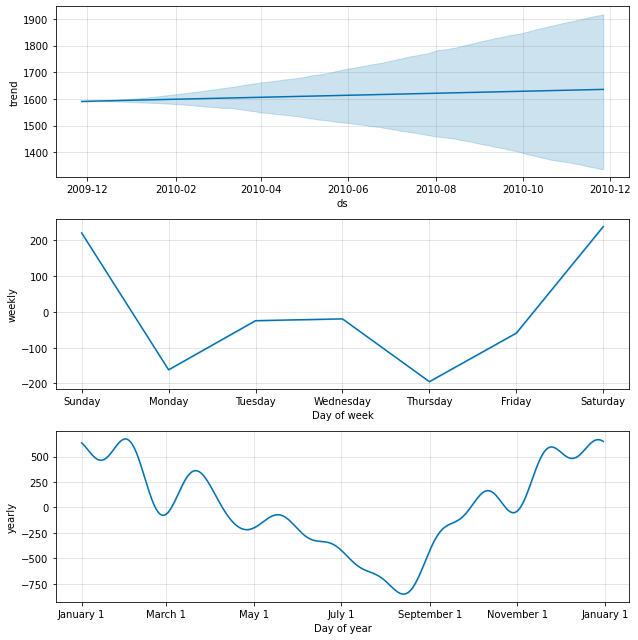

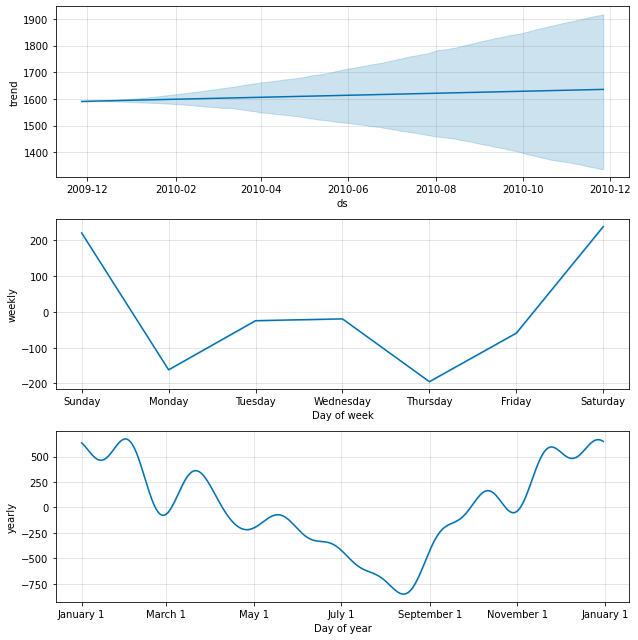

In [35]:
# Plotting the components of the multivariate forecast
model.plot_components(forecast1)